## Comparison of MPM Oedometer with Terzaghi analytical solution

In [48]:
import os
import math
import numpy as np
import pandas as pd
from frake import Anura3DResults as A3D_Results

import matplotlib.pyplot as plt

In [49]:
from lib.anura3D_funcs import get_num_elements, get_num_MPs_per_element, get_num_solid_MPs

from lib.consolidation_funcs import find_time_factor, calc_hydraulic_conductivity, calc_coeff_volume_change, calc_coeff_consolidation,\
                                    calc_time_factor, calc_terzhagi_pore_pressure, calc_normalized_pore_pressure,\
                                    plot_settlement

from lib.string_funcs import closest_row_indices

### Terzaghi - Small strain solution

#### Pore Pressure Solution

In [41]:
# Numerical Model Params (# Assume constant for all models)
num_loadsteps     = 50   # [-], number of loadsteps in Anura3D model 
time_per_loadstep = 0.05 # [s], time per load step in Anura3D model
model_time = num_loadsteps * time_per_loadstep #[s], total model time

applied_load = 2e3       # [Pa]
g = 9.81                 # [m/s^2], gravity
young_modulus = 1000e3   # [Pa], E
poisson_ratio = 0.3      # [-], nu

## Fluid properties
water_density = 1000               # [kg/m^3], rho_l
dynamic_viscosity = 1.002e-6 * 1e3 # [Pa-s]
intrinsic_permeability = 1.0214e-9 # [m^2], NOT the same as hydraulic conductivity

## Geometry properties
init_soil_height = 1  # [m], initial soil height


# Analytical model and plot Parameters and 
num_plot_times     = 10
num_spatial_points = 40
num_iterations = 1000 # Number of iterations for the infinite summation in terzaghi solution

In [50]:
model_directories = [r"C:\Geotech_Research\Quad_Elements\quad_elem_tutorial_models\oedometer\2D_problems\Oedo_LE_2D_v2_6.A3D",
                     r"C:\Geotech_Research\Quad_Elements\quad_elem_tutorial_models\oedometer\2D_problems\Oedo_LE_2D_v2_7_B_bar.A3D",

                    ]

num_models = len(model_directories)

results_list = []
for dir in model_directories:
    # Read  Data from GOM files
    num_elements = get_num_elements(dir)
    num_MP_per_element = get_num_MPs_per_element(dir)
    num_MPs = get_num_solid_MPs(dir)
    
    # Store Par files results
    dummy_results = A3D_Results.OpenModels(dir, IsMultiple=False, Import = "entire", ID = [100], GetNames= 'automaticpar')
    results_list.append(dummy_results)
        

In [42]:
# Specify the target degree of consolidation the results should be plotted for
target_degree_consol  = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5,  0.6, 0.7, 0.8, 0.9, 0.95])

spatial_array  = np.linspace(0.01, init_soil_height, num_spatial_points) # Array of spatial points where the analytical solution will be evaluated

# plot_time = np.array([0, 0.1,  0.15, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5]) #np.linspace(0, model_time, num_plot_times) # Times that pore pressure will be plotted
plot_time_factors = np.zeros(len(target_degree_consol))

for i, U in enumerate(target_degree_consol):
    plot_time_factors[i] = find_time_factor(U, 1e-10)

c:\Users\johnm\anaconda3\envs\Virginia_Tech_Research\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


#### Evaluate consolidation parameters

In [43]:
unit_wt_water = g * water_density #[N/m^3], Unit weight of water

hydraulic_conductivity = calc_hydraulic_conductivity(intrinsic_permeability, unit_wt_water, dynamic_viscosity)

coeff_volume_change = calc_coeff_volume_change(young_modulus, poisson_ratio) # [strain/stress] - mv -> Inverse of the constrained modulus (Eoed) 

coeff_consolidation = calc_coeff_consolidation(hydraulic_conductivity, coeff_volume_change, unit_wt_water) #[m^2/s] - side note it's a viscosity term

#### Find closest values in PAR files to plot_time_factor_times

In [44]:
# init list to hold rows of model dfs that match closest to the selected times
model_row_indices = [None] * len(results_list)

# For each model find the rows that have the closet times
for i, model in  enumerate(results_list):
    for j, MP_data in enumerate(model.DATA):
        # Calculate and append the time factor values
        MP_data["Time_Factor"] =  calc_time_factor(coeff_consolidation, MP_data["Time"], init_soil_height)

    row_indices = closest_row_indices(model.DATA[0], "Time_Factor", plot_time_factors, tol = 0.05)
    model_row_indices[i] = row_indices    


#### Normalized Pore Pressure Plot

In [1]:
num_rows = 2
num_cols = math.ceil(num_models/num_rows)
fig, axs = plt.subplots(nrows = num_rows, ncols= num_cols, figsize = (8, 8))

num_lines = len(plot_time_factors)
lower_time = 0
upper_time = num_lines

# Generate an array of colors based on a colormap
colormap = plt.cm.tab20b
colors = [colormap(i) for i in np.linspace(0.2, 1, num_lines)]

for i, ax in enumerate(axs.reshape(-1)):
    for j, Tv in enumerate(plot_time_factors[lower_time:upper_time]):
        # Analytical (theoretical) solution calculations
        theo_pressure = calc_terzhagi_pore_pressure(applied_load, spatial_array, init_soil_height, Tv, num_iterations)
        
        # Normalize the pore pressures
        theo_normalized_pressure = calc_normalized_pore_pressure(theo_pressure, applied_load)
        # if Tv == 0:
        #     print(theo_pressure)
        # Plot the solution anlytical for t_i
        ax.plot(theo_normalized_pressure, spatial_array, c= colors[j+lower_time])

for i, ax in enumerate(axs.reshape(-1)[:num_models]):
    # Plot each model independently
    model = results_list[i]

    # Select the data from each MP
    for  mp_data in model.DATA:
        # Select the plot time rows
        plot_df = mp_data.iloc[model_row_indices[i][lower_time:upper_time]]
        
        normalized_pressure = calc_normalized_pore_pressure(-1 * plot_df["WPressure"]*1e3, applied_load)

        # Plot the pressure data 
        ax.scatter(normalized_pressure, plot_df["Y"], marker = "o", facecolors='none', color = "blue")
    
    ax.set_title(model.project)
    ax.set_xlabel("normalized Water Pressure [-]")
    ax.set_ylabel("Height [m]")
    # ax.legend()


plt.tight_layout()

NameError: name 'math' is not defined

#### Settlement Plot

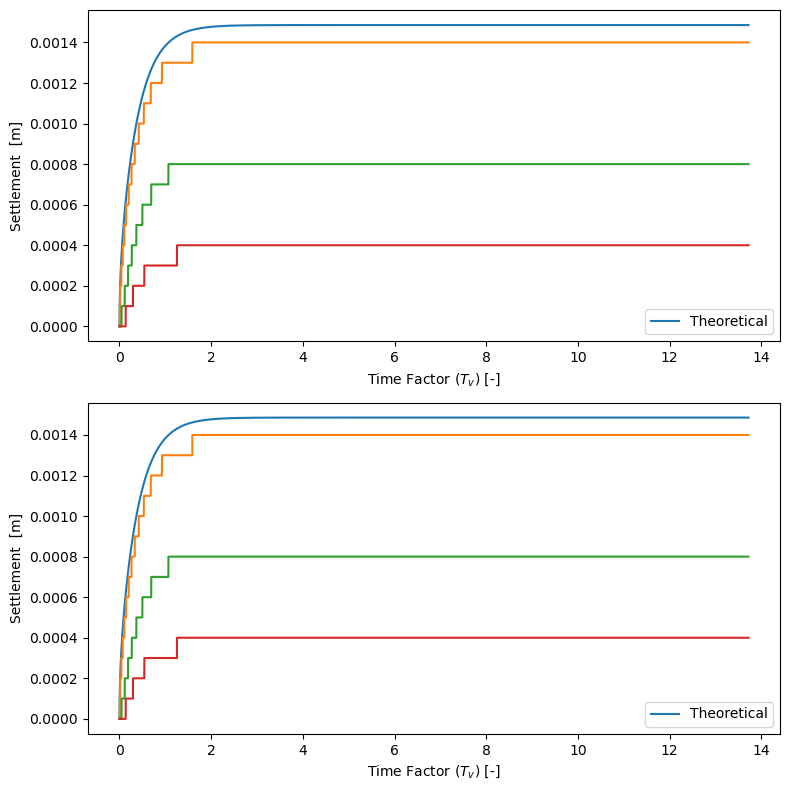

In [47]:
num_rows = 2
num_cols = math.ceil(num_models/num_rows)
fig, axs = plt.subplots(nrows = num_rows, ncols= num_cols, figsize = (8, 8))

for i, model_data in enumerate(results_list):
    # Select the axi handle
    ax = axs.reshape(-1)[i]
    plot_settlement(results_list[0].DATA, coeff_volume_change, applied_load, init_soil_height, ax, plot_theoretical=True)

    # Format Plot
    ax.set_xlabel("Time Factor ($T_{v}$) [-]")
    ax.set_ylabel("Settlement  [m]")
    ax.legend()
plt.tight_layout()